# Bilinear system identification 

In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.linalg import svd
import matplotlib.pyplot as plt
from scipy.linalg import logm

In [2]:
# Magnitudes of the controls
v1 = 1.
v2 = 0.5
# time step for measurements
dt = 1.

In [3]:
def response(*, Ac, Bc, Nc1, Nc2, C):
    
    def rhs_eq(x, t, u1, u2):
        """
        the rhs of the equation of motion
        """
        return (Ac + Nc1 * u1 + Nc2 * u2) @ x + Bc @ (u1, u2)
    
    time = dt * np.arange(20)
        
    # save response when only u1 is on
    responces_1 = []
        
    # save response when only u2 is on
    responces_2 = [] 
        
    for n in range(2, 7):
        # response when only u1 is on
        y_on = odeint(rhs_eq, np.zeros(2), time[:n], args=(v1, 0.))
        y_off = odeint(rhs_eq, y_on[-1], time[(n-1):], args=(0., 0.))[1:]
        
        responces_1.append(
            np.vstack([y_on, y_off]) @ C
        )
            
        # response when only u2 is on
        y_on = odeint(rhs_eq, np.zeros(2), time[:n], args=(0., v2))
        y_off = odeint(rhs_eq, y_on[-1], time[(n-1):], args=(0., 0.))[1:]

        responces_2.append(
             np.vstack([y_on, y_off]) @ C
        )
        
    return np.array(responces_1), np.array(responces_2)

In [4]:
# Matricies from the example in paper
Ac = np.array([[-1, 0], [1, -2]])
Nc1 = np.array([[0, 0], [1, 1]])
Nc2 = np.array([[1, 1], [0, 0]])
Bc = np.array([[1, 0], [0, 1]])
C = np.array([0, 1])

In [5]:
orig_responces_1, orig_responces_2 = response(Ac=Ac, Bc=Bc, Nc1=Nc1, Nc2=Nc2, C=C)

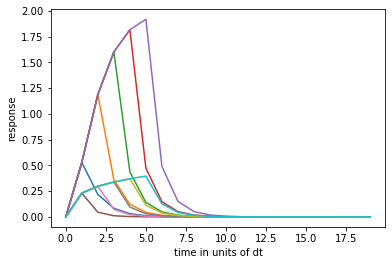

In [6]:
plt.plot(orig_responces_1.T)
plt.plot(orig_responces_2.T)
plt.xlabel("time in units of dt")
plt.ylabel("response")
plt.show()

##  Going to different representation via randomly generated transformation matrix

In [7]:
Phi = np.random.rand(4).reshape(2,2) - 0.5
Phi_inv = np.linalg.inv(Phi)

In [8]:
responces_1, responces_2 = response(
    Ac= Phi_inv @ Ac @ Phi, 
    Bc= Phi_inv @ Bc, 
    Nc1= Phi_inv @ Nc1 @ Phi, 
    Nc2= Phi_inv @ Nc2 @ Phi, 
    C=C @ Phi
)

In [9]:
print("Does responces coinside?")
np.allclose(orig_responces_1, responces_1) and np.allclose(orig_responces_2, responces_2)

Does responces coinside?


True

# System identification

In [10]:
def hankel_pairs (  v = np.array([111,112,121,122,131,132]),
                    h = np.array([211,212,221,222,231,232,241,242]) ):
    v = np.asarray(v).ravel()
    h = np.asarray(h).ravel()
    a, b = np.ogrid[0:len(v), 0:len(h)]
    indx = a + b
    for i in range(1, len(v)): indx[i:, :] = indx[i:, :] + 1
    vals = np.concatenate((v, h))
    return(vals[indx[:int(len(v)/2), :]])

In [11]:
hankel_pairs()

array([[111, 112, 121, 122, 131, 132, 211, 212],
       [121, 122, 131, 132, 211, 212, 221, 222],
       [131, 132, 211, 212, 221, 222, 231, 232]])

In [12]:
Y1 = np.vstack([orig_responces_1[0], orig_responces_2[0]]).T

In [13]:
# declare parameters
m = 1 # number of outputs 
r = 2 # number of controls
alpha = 5
beta = 6

In [14]:
# Eq. (19) in [Juang - 2005]
# H1 = hankel_pairs(Y1[1:(alpha + 1)], Y1[(alpha + 1):(alpha + beta + 1)])

In [15]:
# Eq. (21) in [Juang - 2005]
# U1, Sigma1, V1_T = np.linalg.svd(H1, full_matrices=False)

In [16]:
U1, Sigma1, V1_T = np.linalg.svd(hankel_pairs(Y1[1:10], Y1[10:]), full_matrices=False)

In [17]:
Sigma1

array([6.75358026e-01, 4.89219935e-02, 1.37403357e-08, 1.20855504e-08,
       8.65689577e-09, 4.31760747e-09, 3.26453519e-09, 3.05597395e-09,
       2.59263811e-09])

In [18]:
# we see that the rank of the system is 2
rank = 2

In [19]:
# Eq. (27) in [Juang - 2005]
C_reconstructed = U1[:m, :rank]

In [20]:
C_reconstructed

array([[-0.92526511,  0.37603953]])

In [21]:
# Eqs. (29) and (30) in [Juang - 2005]
U1_up = U1[:-m,]
U1_down = U1[m:,]

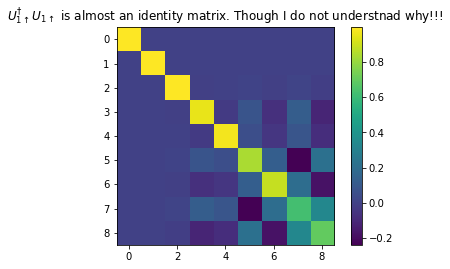

In [22]:
plt.title('$U_{1\\uparrow}^{\dagger}U_{1\\uparrow}$ is almost an identity matrix. Though I do not understnad why!!!')
plt.imshow(U1_up.conj().T @ U1_up)
plt.colorbar()
plt.show()

In [23]:
# Original Eq. (32) in [Juang - 2005], which works but I do not understand why it works 
Ac_reconstructed_original_formula = logm(
    (U1_up.conj().T @ U1_down)[:rank, :rank]
) / dt

# I think the correct form of Eq. (32) is 
Ac_reconstructed = logm(np.linalg.lstsq(U1_up, U1_down, rcond=None)[0][:rank, :rank]) / dt

# even though the results are identical
np.allclose(Ac_reconstructed, Ac_reconstructed_original_formula)

True

In [24]:
# Eq. (28) in [Juang - 2005] 
B1_bar = (Sigma1[..., None] * V1_T)[:rank, :r] # the same as (np.diag(Sigma1) @ V1_T)[:, :r]

In [25]:
U1 = U1[:(alpha * m), :rank]
V1_T = V1_T[:(beta * r), :rank]
Sigma1 = Sigma1[:rank]

In [26]:
# !!!!!!!!!!!!!!!!!!!! this is not quite !!!!!!!!!!!!!!!!

Ac_reconstructed, np.array([[-1.0629, 3.9782], [0.0148, -1.9371]])

(array([[-0.95084945,  3.94885029],
        [-0.01305895, -2.04915058]]),
 array([[-1.0629,  3.9782],
        [ 0.0148, -1.9371]]))

In [27]:
# Eq. (36) in [Juang - 2005] 
H2 = np.vstack([orig_responces_1[1], orig_responces_2[1]]).T
H2 = H2[2:(alpha + 2)]

In [28]:
# Note that U1 is nearly unitary, which is a good news so Eq. (38) is applicable
U1.conj().T @ U1

array([[ 9.99950068e-01, -1.86724544e-04],
       [-1.86724544e-04,  9.99301725e-01]])

In [29]:
# Eq. (38) in [Juang - 2005] 
B2_bar = U1.conj().T @ H2

In [30]:
# Eq. (41) in [Juang - 2005] 
H3 = np.vstack([orig_responces_1[2], orig_responces_2[2]]).T
H3 = H3[3:(alpha + 3)]

H4 = np.vstack([orig_responces_1[3], orig_responces_2[3]]).T
H4 = H4[4:(alpha + 4)]

H5 = np.vstack([orig_responces_1[4], orig_responces_2[4]]).T
H5 = H5[5:(alpha + 5)]

In [31]:
# Eq. (43) in [Juang - 2005]
B3_bar = U1.conj().T @ H3
B4_bar = U1.conj().T @ H4
B5_bar = U1.conj().T @ H5

In [32]:
B_bar = [B1_bar, B2_bar - B1_bar, B3_bar - B2_bar, B4_bar - B3_bar, B5_bar - B4_bar]

In [33]:
C1 = np.vstack([b[:, 0] for b in B_bar]).T
C2 = np.vstack([b[:, 1] for b in B_bar]).T

In [34]:
C1_left = C1[:, :-1]
C1_right = C1[:, 1:]

C2_left = C2[:, :-1]
C2_right = C2[:, 1:]

In [35]:
# NOTE C1_left is NOT RIGHT-UNITARY
C1_left @ C1_left.conj().T

array([[ 0.9942401 , -0.11104432],
       [-0.11104432,  0.02305735]])

In [36]:
# Eq. (54) in [Juang - 2005]. I think this Eq may be incorect!!!
#log_A1_bar = logm(C1_right @ C1_left.conj().T)
#log_A2_bar = logm(C2_right @ C2_left.conj().T)

# the corrected version should be
log_A1_bar = logm(np.linalg.lstsq(C1_left.conj().T, C1_right.conj().T, rcond=None)[0].conj().T)
log_A2_bar = logm(np.linalg.lstsq(C2_left.conj().T, C2_right.conj().T, rcond=None)[0].conj().T)

Nc1_reconstructed = (log_A1_bar / dt - Ac_reconstructed) / v1
Nc2_reconstructed = (log_A2_bar / dt - Ac_reconstructed) / v2

In [37]:
def series_in_Eq52(y):
    """
    Series in Eqs. (52) in [Juang - 2005]
    """
    
    result = np.eye(rank) * dt
    
    r = 2

    term = np.eye(rank) * dt
    
    while np.linalg.norm(term) > 1e-10:
        term = term @ y
        term *= dt / r
        r += 1
        result += term
    
    return np.linalg.inv(result) 

In [38]:
# Eqs. (52) and (53) in [Juang - 2005]
Bc_reconstructed = np.vstack([
    series_in_Eq52(log_A1_bar / dt) @ B1_bar[:, 0] / v1, 
    series_in_Eq52(log_A2_bar / dt) @ B1_bar[:, 1] / v2,
]).T

## Our reconstructed responses 

In [39]:
responces_1, responces_2 = response(
    Ac = Ac_reconstructed,
    Bc = Bc_reconstructed,
    Nc1 = Nc1_reconstructed, 
    Nc2 = Nc2_reconstructed, 
    C = C_reconstructed[0]
)

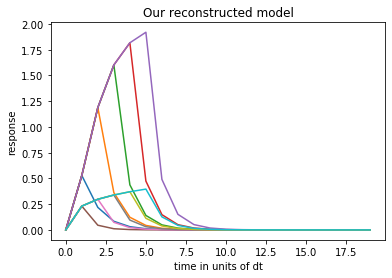

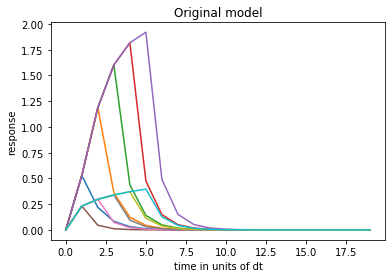

In [40]:
plt.title("Our reconstructed model")
plt.plot(responces_1.T)
plt.plot(responces_2.T)
plt.xlabel("time in units of dt")
plt.ylabel("response")
plt.show()

plt.title("Original model")
plt.plot(orig_responces_1.T)
plt.plot(orig_responces_2.T)
plt.xlabel("time in units of dt")
plt.ylabel("response")
plt.show()


In [41]:
# difference between the response of the reconstructed model and the original model is small
# which is GREAT
np.abs(responces_1 - orig_responces_1).max(), np.abs(responces_2 - orig_responces_2).max()

(0.0001986889848342166, 5.7295133242096785e-05)

## Comparing to example in the paper

In [42]:
paper_responces_1, paper_responces_2 = response(
    Ac = np.array([[-1.0629, 3.9782], [0.0148, -1.9371]]),
    Bc = np.array([[-0.0929, -0.9824], [-0.2484, 0.2314]]),
    Nc1 = np.array([[1.7752, 3.2911], [-0.4182, -0.7752]]), 
    Nc2 = np.array([[0.1678, 0.3111], [0.4489, 0.8322]]), 
    C = np.array([-0.9355, 0.3497])
)

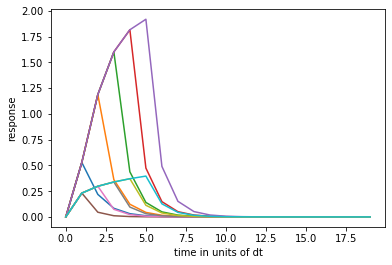

In [43]:
plt.plot(paper_responces_1.T)
plt.plot(paper_responces_2.T)
plt.xlabel("time in units of dt")
plt.ylabel("response")
plt.show()